# <center>House Prices - Advanced Regression Techniques</center> 

<center>House Prices - Advanced Regression Techniques<br/>
Predict sales prices and practice feature engineering, RFs, and gradient boosting</center>

The data was collected from a <a href ='https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview'>Kaggle Competition </a>

### Competition Description:<br/>


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Acknowledgments
The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

## Data Wrangling

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#set plotting style
sns.set_style("whitegrid")
sns.set_palette("pastel")

The data is provided in 2 different files, train.csv, test.csv and predict.csv <br>
for this notebook we will load them separately as data and to_predict

In [2]:
# read the data
data = pd.read_csv('data/train.csv')
to_predict = pd.read_csv('data/test.csv')

In [3]:
data.shape, to_predict.shape

((1460, 81), (1459, 80))

The sets have similiar dimensions, The `data` set has an extra column, the target.

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
to_predict.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


---

### Check for dublicates

The "to_predict" dataset contains the same number of entries as the dataset we'll employ for training and evaluating our model. With a larger dataset, the likelihood of errors occurring during data entry, importation, and other processes increases. It is best to perform duplicate and consistency checks on both datasets individually as well as between the two datasets.

In [6]:
#check for dublicates in both dataframes individually
len(data[data.duplicated()]), len(to_predict[to_predict.duplicated()])

(0, 0)

In [7]:
# check the id column, is it unique?

print('The Id column in TRAIN set is unique: ', len(data.Id.unique()) == len(data)) 
print('The Id column in TEST  set is unique: ', len(to_predict.Id.unique()) == len(to_predict)) 

The Id column in TRAIN set is unique:  True
The Id column in TEST  set is unique:  True


Now compare the two dataframe Id:

In [8]:
# check ids between datasets
ids = pd.concat([data.Id, to_predict.Id])
print('Datasets have unique ids between them:', len(ids.unique()) == len(data) + len(to_predict))

Datasets have unique ids between them: True


lastly, let's see if the sets share any identical row

In [9]:
# merge on columns of to_predict, without the id columns
intersecting_rows = pd.merge(data.drop('Id', axis=1),
                       to_predict.drop('Id', axis=1),
                       on=list(to_predict.drop('Id', axis=1).columns),
                       how='inner')
intersecting_rows

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,160,RM,24.0,2522,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,130000
1,160,FV,24.0,2544,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,147400


There are two rows where the train and test datasets overlap. It's worth noting that these duplicated rows between  'test.csv' and 'train.csv' won't pose any issues since 'test.csv' file is solely intended for making predictions and submitting results. <i>(In fact, we could even use these two rows, for which we already know the 'SalePrice' result, to cheat and to manipulate the score slightly when submitting our predictions.)</i>

The crucial point is that the duplicates shouldn't exist between 'train' and 'test' that we will generate form the 'train.csv'. These will be used for model training and evaluation. If duplicates were present in these datasets, they could lead to overfitting. Fortunately, we've already confirmed that 'test.csv' is free of duplicates, so for now we don't have to worry about that aspect.

In [10]:
# get the indixes from to_predict, and save the Ids
intersecting_indices = to_predict.index[to_predict.drop('Id', axis = 1).isin(intersecting_rows.to_dict(orient='list')).all(axis=1)]
ids = to_predict.loc[intersecting_indices]['Id'].values

# add ids to intersecting rows df
intersecting_rows['Id'] = sorted(ids,reverse=True)

# now we have the intersecting_rows, dataframe with their to_predict ID and the predicted prices:
intersecting_rows[['Id','SalePrice']]

,Id,SalePrice
0,2866,130000
1,2714,147400


remove the id column from the data set since it doesn't provide any useful information

In [11]:
data.drop('Id', axis = 1, inplace=True)

### Missing values

In [12]:
# percentage of missing values
data.isnull().sum().sort_values(ascending = False)/data.shape[0]*100

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
                 ...    
Heating         0.000000
HeatingQC       0.000000
MSZoning        0.000000
1stFlrSF        0.000000
SalePrice       0.000000
Length: 80, dtype: float64

In [13]:
# the test.csv
to_predict.isnull().sum().sort_values(ascending = False)/to_predict.shape[0]*100

PoolQC           99.794380
MiscFeature      96.504455
Alley            92.666210
Fence            80.123372
MasVnrType       61.274846
                   ...    
Electrical        0.000000
1stFlrSF          0.000000
2ndFlrSF          0.000000
LowQualFinSF      0.000000
SaleCondition     0.000000
Length: 80, dtype: float64

The test.csv has similiar amount of missing values

The PoolQc is missing 99.5% of its values, MiscFeature 96.3% and so on. We will explore this features, and then decide if we should keep them or delete completely

In [14]:
#poolQc stands for pool quality, a categorical feature
data.PoolQC.value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

this column contains only 7 entries out of 1460. Could it be because the majority of houses don't have pool?

In [15]:
data.filter(like='Pool').columns

Index(['PoolArea', 'PoolQC'], dtype='object')

In [16]:
data.PoolArea.head()

0    0
1    0
2    0
3    0
4    0
Name: PoolArea, dtype: int64

In [17]:
data[data.PoolArea > 0].shape

(7, 80)

indeed, there are only 7 houses with pool area greater than 0. <br>Before filling this 'NA' values, let's split the data between Qualitative and Quantitative variables.

In [18]:
# check the datatypes
data.dtypes.value_counts()

object     43
int64      34
float64     3
Name: count, dtype: int64

from this brief observation, there are 43 qualitative features and 36+1 quantitative, <i>(the '+1' is the sale price)</i>

In [19]:
categorical = data.select_dtypes('object')
numerical   = data.select_dtypes(['int','float']).drop('SalePrice', axis=1) 
categorical.shape[1], numerical.shape[1]

(43, 36)

# Categorical Features 

In [20]:
categorical.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [21]:
# check percentages of missing values for each categorical feature
cat_with_null = categorical.columns[categorical.isnull().sum() >0]
categorical[cat_with_null].isnull().sum().sort_values(ascending=False) / len(categorical)*100

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
Electrical       0.068493
dtype: float64

In [22]:
# fill the poolQC with None

categorical.PoolQC.fillna('None', inplace=True)

In [23]:
categorical.MiscFeature.value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [24]:
categorical.MiscFeature.fillna('None', inplace=True)

All Garage features have same amount of missing data, same trend can be noticed for Basement. Fireplace quality has 47% of rows missing, lets investigate the importance of this column

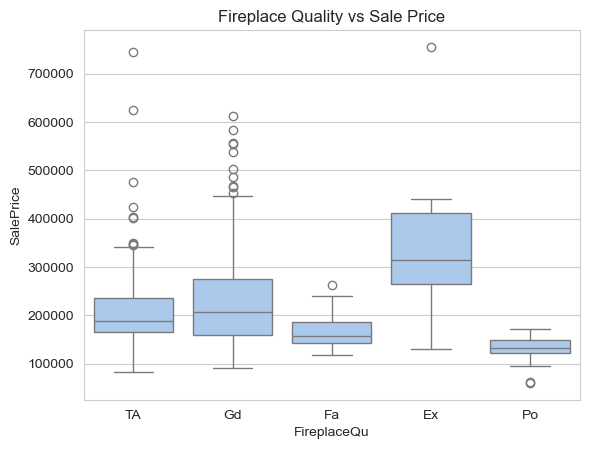

In [25]:
# boxplot target and fireplace 
sns.boxplot(x="FireplaceQu", y="SalePrice", data=data)
plt.title('Fireplace Quality vs Sale Price')
plt.show();

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

Box plots indicate that houses equipped with Excellent-quality fireplaces tend to have higher selling prices, there are quite  a few outliers aswell. The dataset's substantial number of NULL values in the 'Fireplace Quality' category, which was set as NA

Before we proceed to assign a value to all the missing entries, let's take a closer look at the 'Fireplaces' column, which indicates the number of fireplaces in each property

In [26]:
data.loc[data.FireplaceQu.isnull(), 'Fireplaces'].value_counts()

Fireplaces
0    690
Name: count, dtype: int64

All rows of Fireplace Quality with null values have value 0 in fireplaces column. <br>
Fill all categorical missing values with 'None':

In [27]:
categorical.fillna('None', inplace=True)
to_predict[categorical.columns] = to_predict[categorical.columns].fillna('None')

In [28]:
categorical.isnull().sum().sum()

0

### Datetime Features:

In [29]:
numerical['MoSold'].isnull().sum(), numerical['YrSold'].isnull().sum()

(0, 0)

no missing values for this columns.

How has the housing price change over the years?

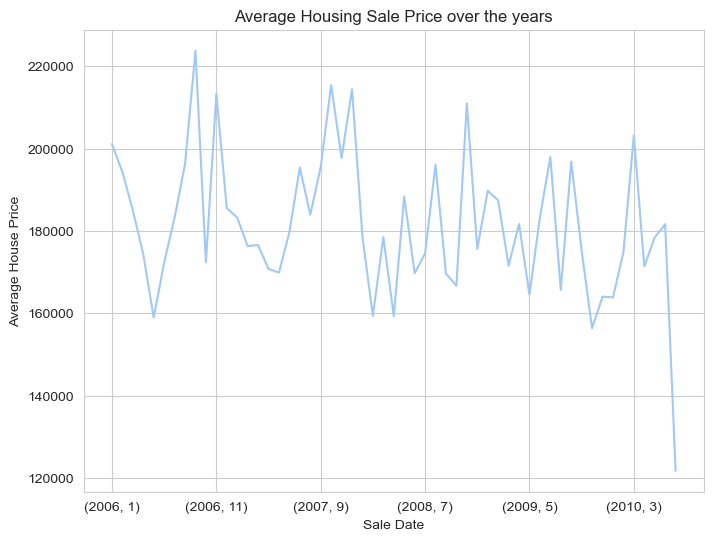

In [30]:
plt.figure(figsize=(8,6))
data.groupby(['YrSold', 'MoSold'])['SalePrice'].mean().plot()
plt.title('Average Housing Sale Price over the years')
plt.xlabel('Sale Date')
plt.ylabel('Average House Price');

In [31]:
other_dates = ['YearBuilt', 'YearRemodAdd','GarageYrBlt']
for year in other_dates:
    print('{} has {} missing values in the train set'.format(year, numerical[year].isnull().sum()))
    print('{} has {} missing values in the test set\n'.format(year, to_predict[year].isnull().sum()))

YearBuilt has 0 missing values in the train set
YearBuilt has 0 missing values in the test set

YearRemodAdd has 0 missing values in the train set
YearRemodAdd has 0 missing values in the test set

GarageYrBlt has 81 missing values in the train set
GarageYrBlt has 78 missing values in the test set



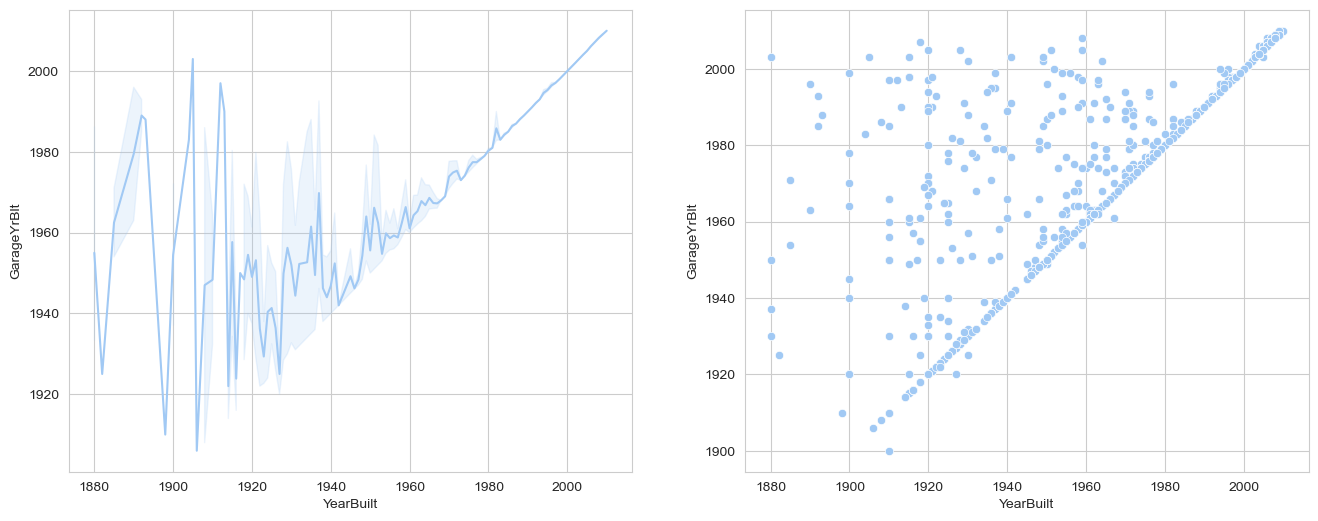

In [32]:
# year built vs garage
fig, ax = plt.subplots(1,2, figsize = (16,6))
sns.lineplot(data = numerical, x = 'YearBuilt', y = 'GarageYrBlt', ax = ax[0])
sns.scatterplot(data = numerical, x = 'YearBuilt', y = 'GarageYrBlt', ax = ax[1]);

Observing the line plot depicting the construction years of houses and their associated garage construction years, it becomes evident that older houses have had garages added to them in more recent times. This phenomenon can be attributed to the fact that before the 1940s, a significant number of households did not own cars. However, a noticeable trend emerges post the 1940s, and by the 1960s, the curve levels off, indicating that houses constructed after this decade typically include garages as a standard feature. Imputing Garage Year Built with the House Year built seems a reasonable approach

In the scatterplot we can notice some instances where the garage was built before the house:

In [33]:
numerical[numerical.YearBuilt > numerical.GarageYrBlt][['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']]

,YearBuilt,YearRemodAdd,GarageYrBlt
29,1927,1950,1920.0
93,1910,1998,1900.0
324,1967,2007,1961.0
600,2005,2005,2003.0
736,1950,1950,1949.0
1103,1959,1959,1954.0
1376,1930,1950,1925.0
1414,1923,2000,1922.0
1418,1963,1963,1962.0


In [34]:
# fill Garage Year with YearBuilt, and convert to datetime
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)
to_predict['GarageYrBlt'].fillna(to_predict['YearBuilt'], inplace=True)

### Other Numerical Features

Check the missing values as percentage

In [35]:
(numerical.isnull().sum().sort_values(ascending = False)/numerical.shape[0]*100).head()

LotFrontage     17.739726
GarageYrBlt      5.547945
MasVnrArea       0.547945
WoodDeckSF       0.000000
BedroomAbvGr     0.000000
dtype: float64

there are 2 columns with missing data:

LotFrontage: Linear feet of street connected to property<br>
MasVnrArea: Masonry veneer area in square feet

let's plot them 

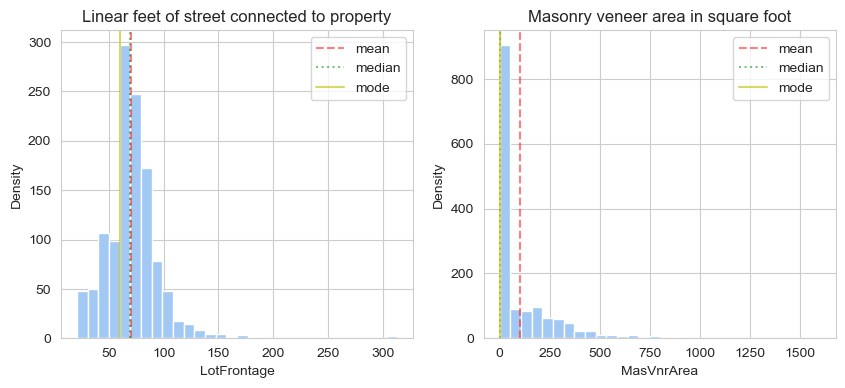

In [36]:
fig, ax = plt.subplots(1,2, figsize = (10,4))

ax[0].hist(data['LotFrontage'], bins = 30)
ax[0].axvline(data.LotFrontage.mean(), c='r', linestyle='--', label='mean' , alpha = 0.5)
ax[0].axvline(data.LotFrontage.median(),linestyle=':', c='g', label='median' , alpha = 0.5)
ax[0].axvline(data.LotFrontage.mode()[0],linestyle='-',c = 'y', label='mode' , alpha = 0.6)
ax[0].set_title('Linear feet of street connected to property')
ax[0].set_xlabel('LotFrontage')
ax[0].set_ylabel('Density')
ax[0].legend();

ax[1].hist(data['MasVnrArea'], bins = 30)
ax[1].axvline(data.MasVnrArea.mean(), c='r',linestyle='--', label='mean', alpha = 0.5)
ax[1].axvline(data.MasVnrArea.median(),linestyle=':', c='g', label='median', alpha = 0.5)
ax[1].axvline(data.MasVnrArea.mode()[0],linestyle='-', c='y',label='mode', alpha = 0.6)
ax[1].set_title('Masonry veneer area in square foot')
ax[1].set_xlabel('MasVnrArea')
ax[1].set_ylabel('Density')
ax[1].legend();

LotFrontage has the same mean and median. For MasVnrArea will impute with mode. 

In [37]:
numerical.LotFrontage.fillna(data.LotFrontage.mean(), inplace=True)
numerical.MasVnrArea.fillna(data.MasVnrArea.mode()[0], inplace=True)

In [38]:
to_predict.LotFrontage.fillna(numerical.LotFrontage.mean(), inplace=True)
to_predict[numerical.columns].fillna(numerical.mode(), inplace = True)

C:\Users\GENTI\AppData\Local\Temp\ipykernel_4252\1241062944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  to_predict[numerical.columns].fillna(numerical.mode(), inplace = True)


-----

saving the changes:

In [39]:
# null values before
data.isnull().sum().sum()

7748

In [40]:
# now we save the changes:
data[categorical.columns] = categorical
data[numerical.columns]  = numerical

In [41]:
# null values after
data.isnull().sum().sum()

81

---

#### Check the distribution of the Sale Price

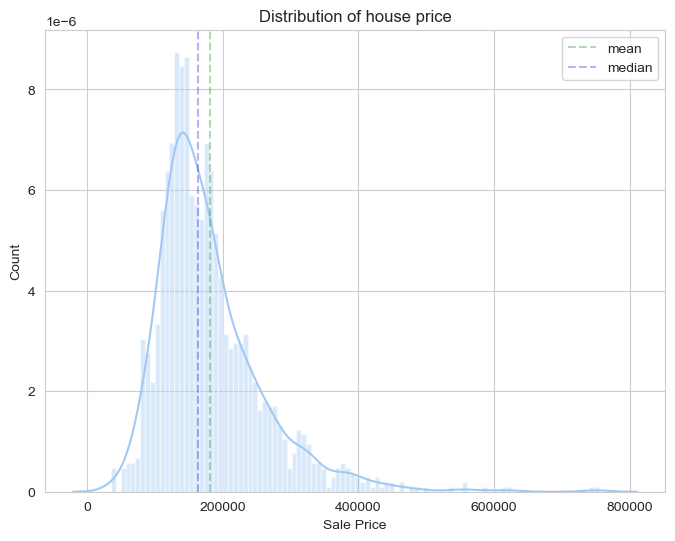

In [42]:
import warnings
warnings.filterwarnings(action='ignore')

plt.figure(figsize=(8,6))
sns.distplot(data.SalePrice, bins=100)
plt.title('Distribution of house price')
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.axvline(data.SalePrice.mean(), c='g', linestyle='--', label='mean', alpha = 0.3)
plt.axvline(data.SalePrice.median(), c='b', linestyle='--', label='median', alpha = 0.3)

plt.legend()
plt.show();

The mean and the median of the house prices are shifted to the right of the highest peak of the line, this is due some outliers. There are some very high house prices that are skewing the data and making the overall SalePrice from our dataset not normally distributed. This means that if we are going to try training any regression model, we will need to tranform the data to be nirmally distributed first.

Print all the datatypes from the dataset:

In [43]:
data.dtypes.value_counts()

object     43
int64      34
float64     3
Name: count, dtype: int64

In [44]:
numerical.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.000000,70.00,190.0
LotFrontage,1460.0,70.049958,22.024023,21.0,60.00,70.049958,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.500000,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.000000,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.000000,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.000000,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.000000,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.000000,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.500000,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.000000,0.00,1474.0


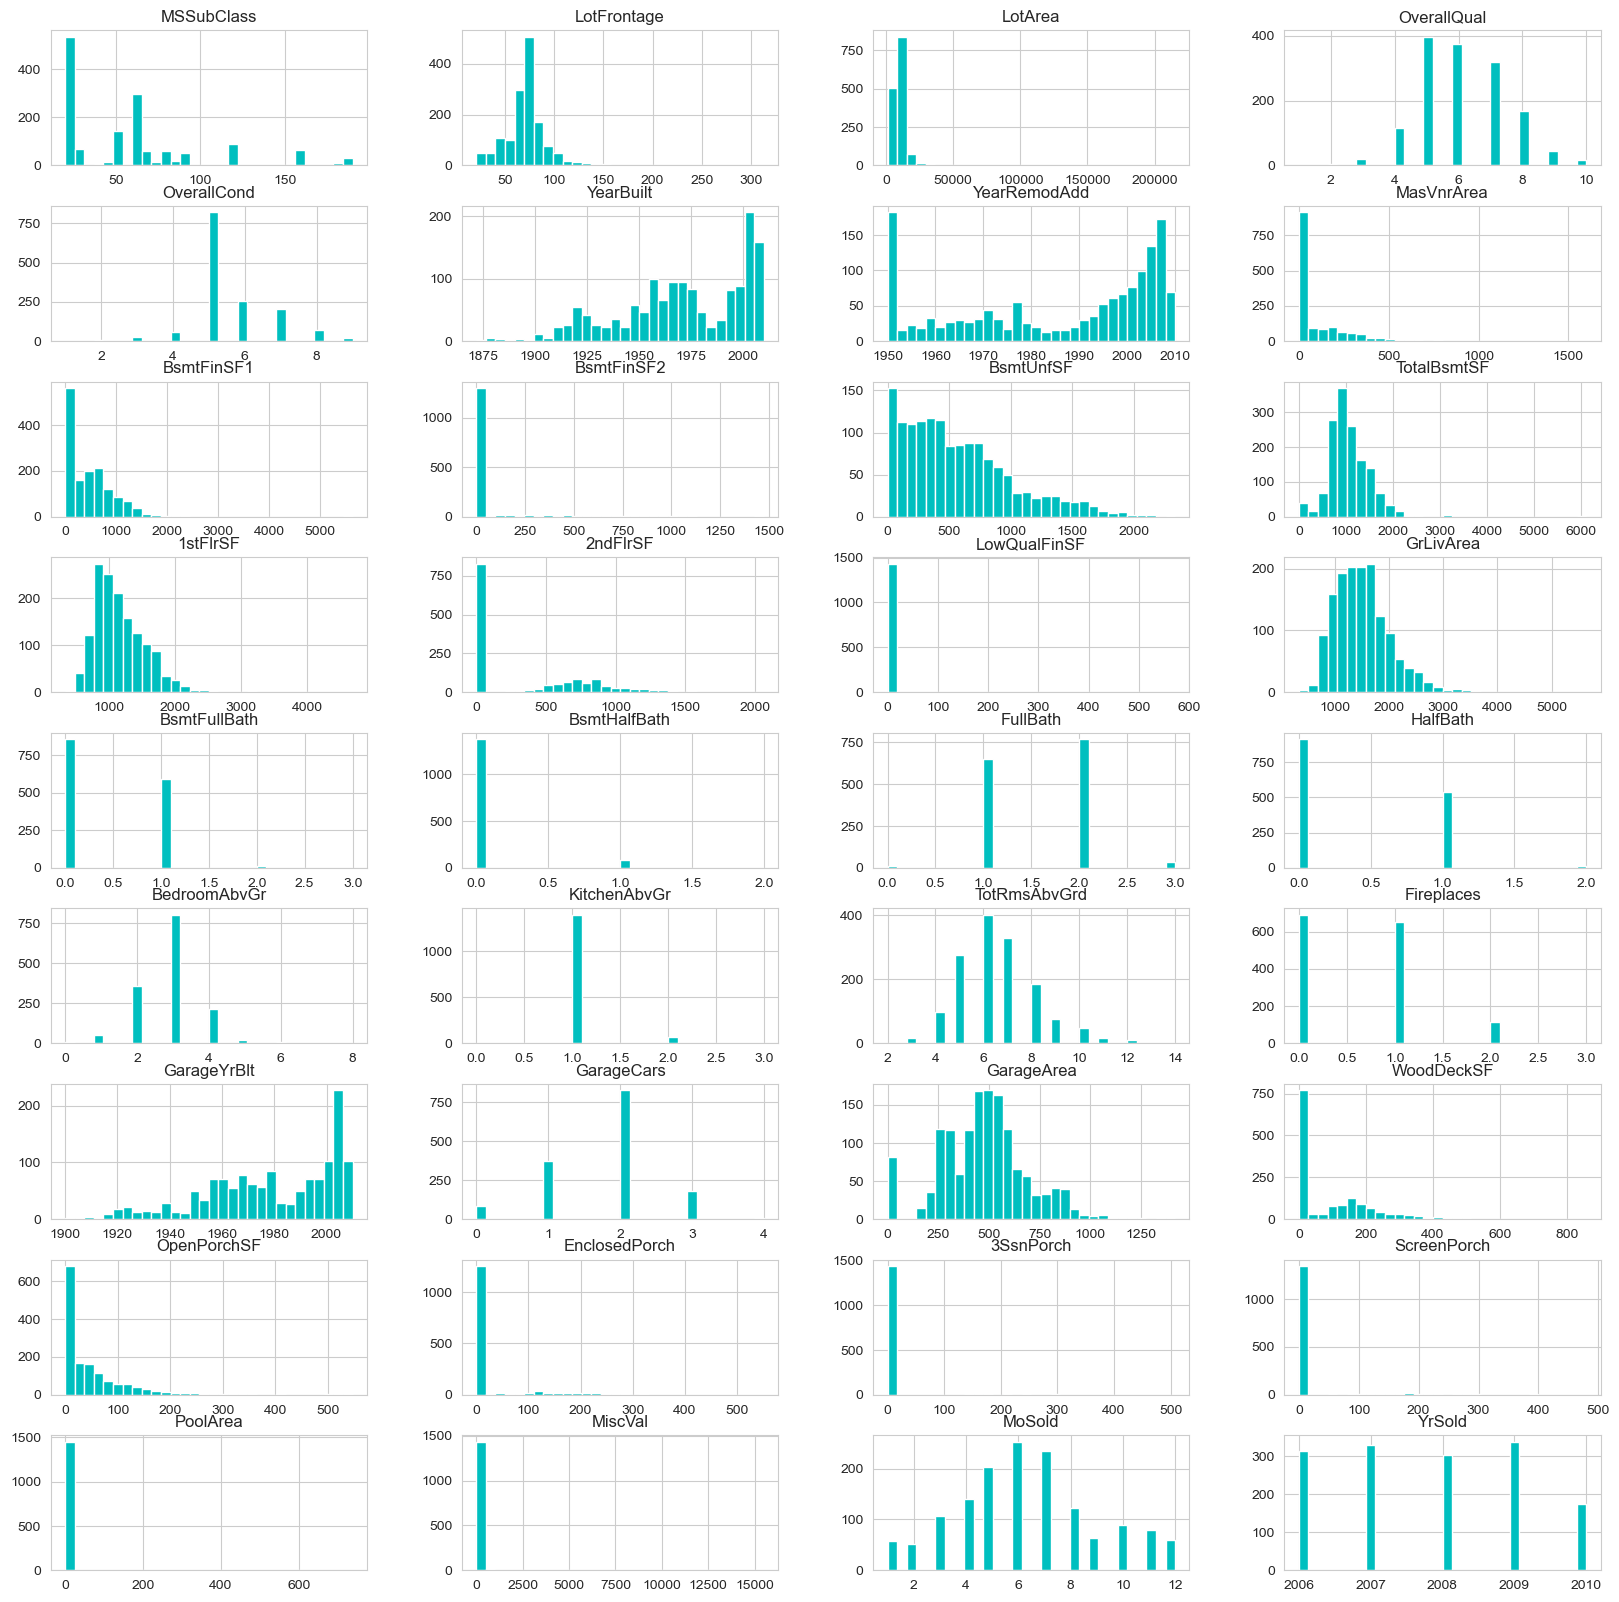

In [45]:
numerical.hist(figsize=(20, 20), bins=30, layout=(9,4), color ='c');

from this plots we can notive some skewed data and the presence of some possible outliers. We must be very careful when handeling these features

### imbalanced categories

Let's examine the features where more than 95% of the data belongs to the same category

In [46]:
imbalanced = {}
for col in categorical.columns:
    values = categorical[col].value_counts(normalize=True)
    if values.max() > 0.95:
        imbalanced[col] = [values.idxmax(),values[0]]

imbalanced

{'Street': ['Pave', 0.9958904109589041],
 'Utilities': ['AllPub', 0.9993150684931507],
 'Condition2': ['Norm', 0.9897260273972602],
 'RoofMatl': ['CompShg', 0.9821917808219178],
 'Heating': ['GasA', 0.9780821917808219],
 'PoolQC': ['None', 0.9952054794520548],
 'MiscFeature': ['None', 0.963013698630137]}

These categorical columns exhibit significant class imbalance, with some categories containing 99% of the total data points. It is imperative to conduct a thorough analysis of these columns and determine the best course of action. Should we consider removing them entirely? Alternatively, could we group the minority classes into an 'other' category, especially in cases where there are more than two classes? This approach would not only address the imbalance but also offer potential dimensionality reduction, which becomes increasingly beneficial when we proceed with encoding.

### Save the files

In [47]:
data.to_csv('data/imputed_train.csv', index=False)
to_predict.to_csv('data/imputed_test.csv', index=False)

## Summary:

"In this project, we have two datasets at our disposal: 'train.csv,' which encompasses all the features, including the target variable 'Sale Price,' and 'test.csv,' which has the same number of rows but lacks the 'Sale Price' column. Our primary objective in this project is to construct a robust machine learning model capable of predicting the missing 'Sale Price' values for the testing dataset.

To prepare our data for modeling, we have undertaken several essential steps. Initially, we conducted an initial data exploration to assess the relationships between various variables. We proceeded by optimizing the dataset by modifying data types, handling missing values through imputation techniques, and considering of eliminating certain features that are deemed to offer little or no meaningful information. By removing these irrelevant variables, we aim to reduce the dimensionality of the dataset and simplify the model's complexity, with the ultimate goal of enhancing prediction accuracy.

In the upcoming phase, known as 'Exploratory Data Analysis' (EDA), we will delve deeper into the relationships between features. This analysis will involve assessing the significance of individual features, exploring their interdependencies, and identifying any patterns or trends that could provide valuable insights for our predictive model